In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Helper functions for data processing
def extract_base(model_name):
    if 'Llama-2-7B' in model_name:
        return 'Llama-2-7B'
    elif 'Llama-3.1-8B' in model_name:
        return 'Llama-3.1-8B'
    elif 'Viking-7B' in model_name:
        return 'Viking-7B'
    else:
        return 'Other'
    
def extract_data_combination(model_name):
    if 'Bilingual-Code' in model_name:
        return 'Bilingual-Code'
    elif 'Bilingual' in model_name:
        return 'Bilingual'
    elif 'Monolingual-Code' in model_name:
        return 'Monolingual-Code'
    elif 'Monolingual' in model_name:
        return 'Monolingual'
    else:
        return 'Unknown'

In [ ]:
# Connect to Google Sheets and get data
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA Data Mixing Ablation Evaluation")

# Get data from all three worksheets
Altruistic_SIB = spreadsheet.worksheet("Altruistic-Flores-200-X-Eng-BLEU")
Selfish_SIB = spreadsheet.worksheet("Selfish-Flores-200-X-Eng-BLEU")
Stagnant_SIB = spreadsheet.worksheet("Stagnant-Flores-200-X-Eng-BLEU")

Altruistic_SIB_Data = Altruistic_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")
Selfish_SIB_Data = Selfish_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")
Stagnant_SIB_Data = Stagnant_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")

# Define languages and resource levels for each category
altruistic_languages = ['zho_Hans-eng_Latn', 'ceb_Latn-eng_Latn', 'mar_Deva-eng_Latn', 'zul_Latn-eng_Latn', 'khm_Khmr-eng_Latn']
altruistic_resource_map = {
    'zho_Hans-eng_Latn': 'High',
    'ceb_Latn-eng_Latn': 'Mid',
    'mar_Deva-eng_Latn': 'Mid',
    'zul_Latn-eng_Latn': 'Low',
    'khm_Khmr-eng_Latn': 'Low'
}

selfish_languages = ['deu_Latn-eng_Latn', 'bel_Cyrl-eng_Latn', 'mri_Latn-eng_Latn', 'kir_Cyrl-eng_Latn', 'nya_Latn-eng_Latn']
selfish_resource_map = {
    'deu_Latn-eng_Latn': 'High',
    'bel_Cyrl-eng_Latn': 'Mid',
    'mri_Latn-eng_Latn': 'Mid',
    'kir_Cyrl-eng_Latn': 'Low',
    'nya_Latn-eng_Latn': 'Low'
}

stagnant_languages = ['tha_Thai-eng_Latn', 'yor_Latn-eng_Latn', 'sna_Latn-eng_Latn', 'wol_Latn-eng_Latn']
stagnant_resource_map = {
    # 'eng_Latn': 'High',
    'tha_Thai-eng_Latn': 'Mid',
    'yor_Latn-eng_Latn': 'Mid',
    'sna_Latn-eng_Latn': 'Low',
    'wol_Latn-eng_Latn': 'Low'
}

# Combine all languages and resource maps
all_languages = altruistic_languages + selfish_languages + stagnant_languages
all_resource_map = {**altruistic_resource_map, **selfish_resource_map, **stagnant_resource_map}

# Process Altruistic data
df_Altruistic_SIB = pd.DataFrame(Altruistic_SIB_Data)
df_selected_altruistic = df_Altruistic_SIB[['Model'] + altruistic_languages]
df_long_altruistic = df_selected_altruistic.melt(id_vars='Model', var_name='Language', value_name='Score')
df_long_altruistic['Resource_Level'] = df_long_altruistic['Language'].map(altruistic_resource_map)
df_long_altruistic['Language_Type'] = 'Altruistic'

# Process Selfish data
df_Selfish_SIB = pd.DataFrame(Selfish_SIB_Data)
df_selected_selfish = df_Selfish_SIB[['Model'] + selfish_languages]
df_long_selfish = df_selected_selfish.melt(id_vars='Model', var_name='Language', value_name='Score')
df_long_selfish['Resource_Level'] = df_long_selfish['Language'].map(selfish_resource_map)
df_long_selfish['Language_Type'] = 'Selfish'

# Process Stagnant data
df_Stagnant_SIB = pd.DataFrame(Stagnant_SIB_Data)
df_selected_stagnant = df_Stagnant_SIB[['Model'] + stagnant_languages]
df_long_stagnant = df_selected_stagnant.melt(id_vars='Model', var_name='Language', value_name='Score')
df_long_stagnant['Resource_Level'] = df_long_stagnant['Language'].map(stagnant_resource_map)
df_long_stagnant['Language_Type'] = 'Stagnant'

# Combine all data
df_combined = pd.concat([df_long_altruistic, df_long_selfish, df_long_stagnant])

# Extract model information
df_combined['Base_Model'] = df_combined['Model'].apply(extract_base)
df_combined['Data_Combination'] = df_combined['Model'].apply(extract_data_combination)

# Define category orders
data_combination_order = ['Monolingual', 'Monolingual-Code']
resource_order = ['High', 'Mid', 'Low']
base_model_order = ['Llama-3.1-8B', 'Llama-2-7B', 'Viking-7B']

# Convert categories to ordered categorical data
df_combined['Data_Combination'] = pd.Categorical(df_combined['Data_Combination'], categories=data_combination_order, ordered=True)
df_combined['Resource_Level'] = pd.Categorical(df_combined['Resource_Level'], categories=resource_order, ordered=True)
df_combined['Base_Model'] = pd.Categorical(df_combined['Base_Model'], categories=base_model_order, ordered=True)

# Filter to include only the specified base models
df_filtered = df_combined[df_combined['Base_Model'].isin(base_model_order)]

# Calculate baseline scores by averaging across all languages for each resource level and base model
baseline_scores = {}
for base_model in base_model_order:
    for resource_level in resource_order:
        # Filter the data for the base model and resource level
        base_model_data = df_filtered[
            (df_filtered['Model'] == base_model) & 
            (df_filtered['Resource_Level'] == resource_level) &
            (~df_filtered['Data_Combination'].isin(data_combination_order))  # Exclude data combinations
        ]
        
        if not base_model_data.empty:
            # Calculate the average score
            avg_score = base_model_data['Score'].mean()
            baseline_scores[(base_model, resource_level)] = avg_score

# Set the style for the plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 14,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

# Define display names for legend
display_names = {
    'Monolingual': 'Monolingual',
    'Monolingual-Code': 'Monolingual+Code'
}

# Define custom palette to maintain 'Monolingual' color from Set2 and use a new color for 'Monolingual-Code'
custom_palette = {"Monolingual": sns.color_palette("Set2")[1], "Monolingual-Code": sns.color_palette("Set2")[2]}

# Aggregate data by base model, data combination, and resource level (ignoring language type)
df_agg = df_filtered.groupby(['Base_Model', 'Data_Combination', 'Resource_Level'], as_index=False)['Score'].mean()

/tmp/ipykernel_2364552/1846755493.py:131: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df_filtered.groupby(['Base_Model', 'Data_Combination', 'Resource_Level'], as_index=False)['Score'].mean()


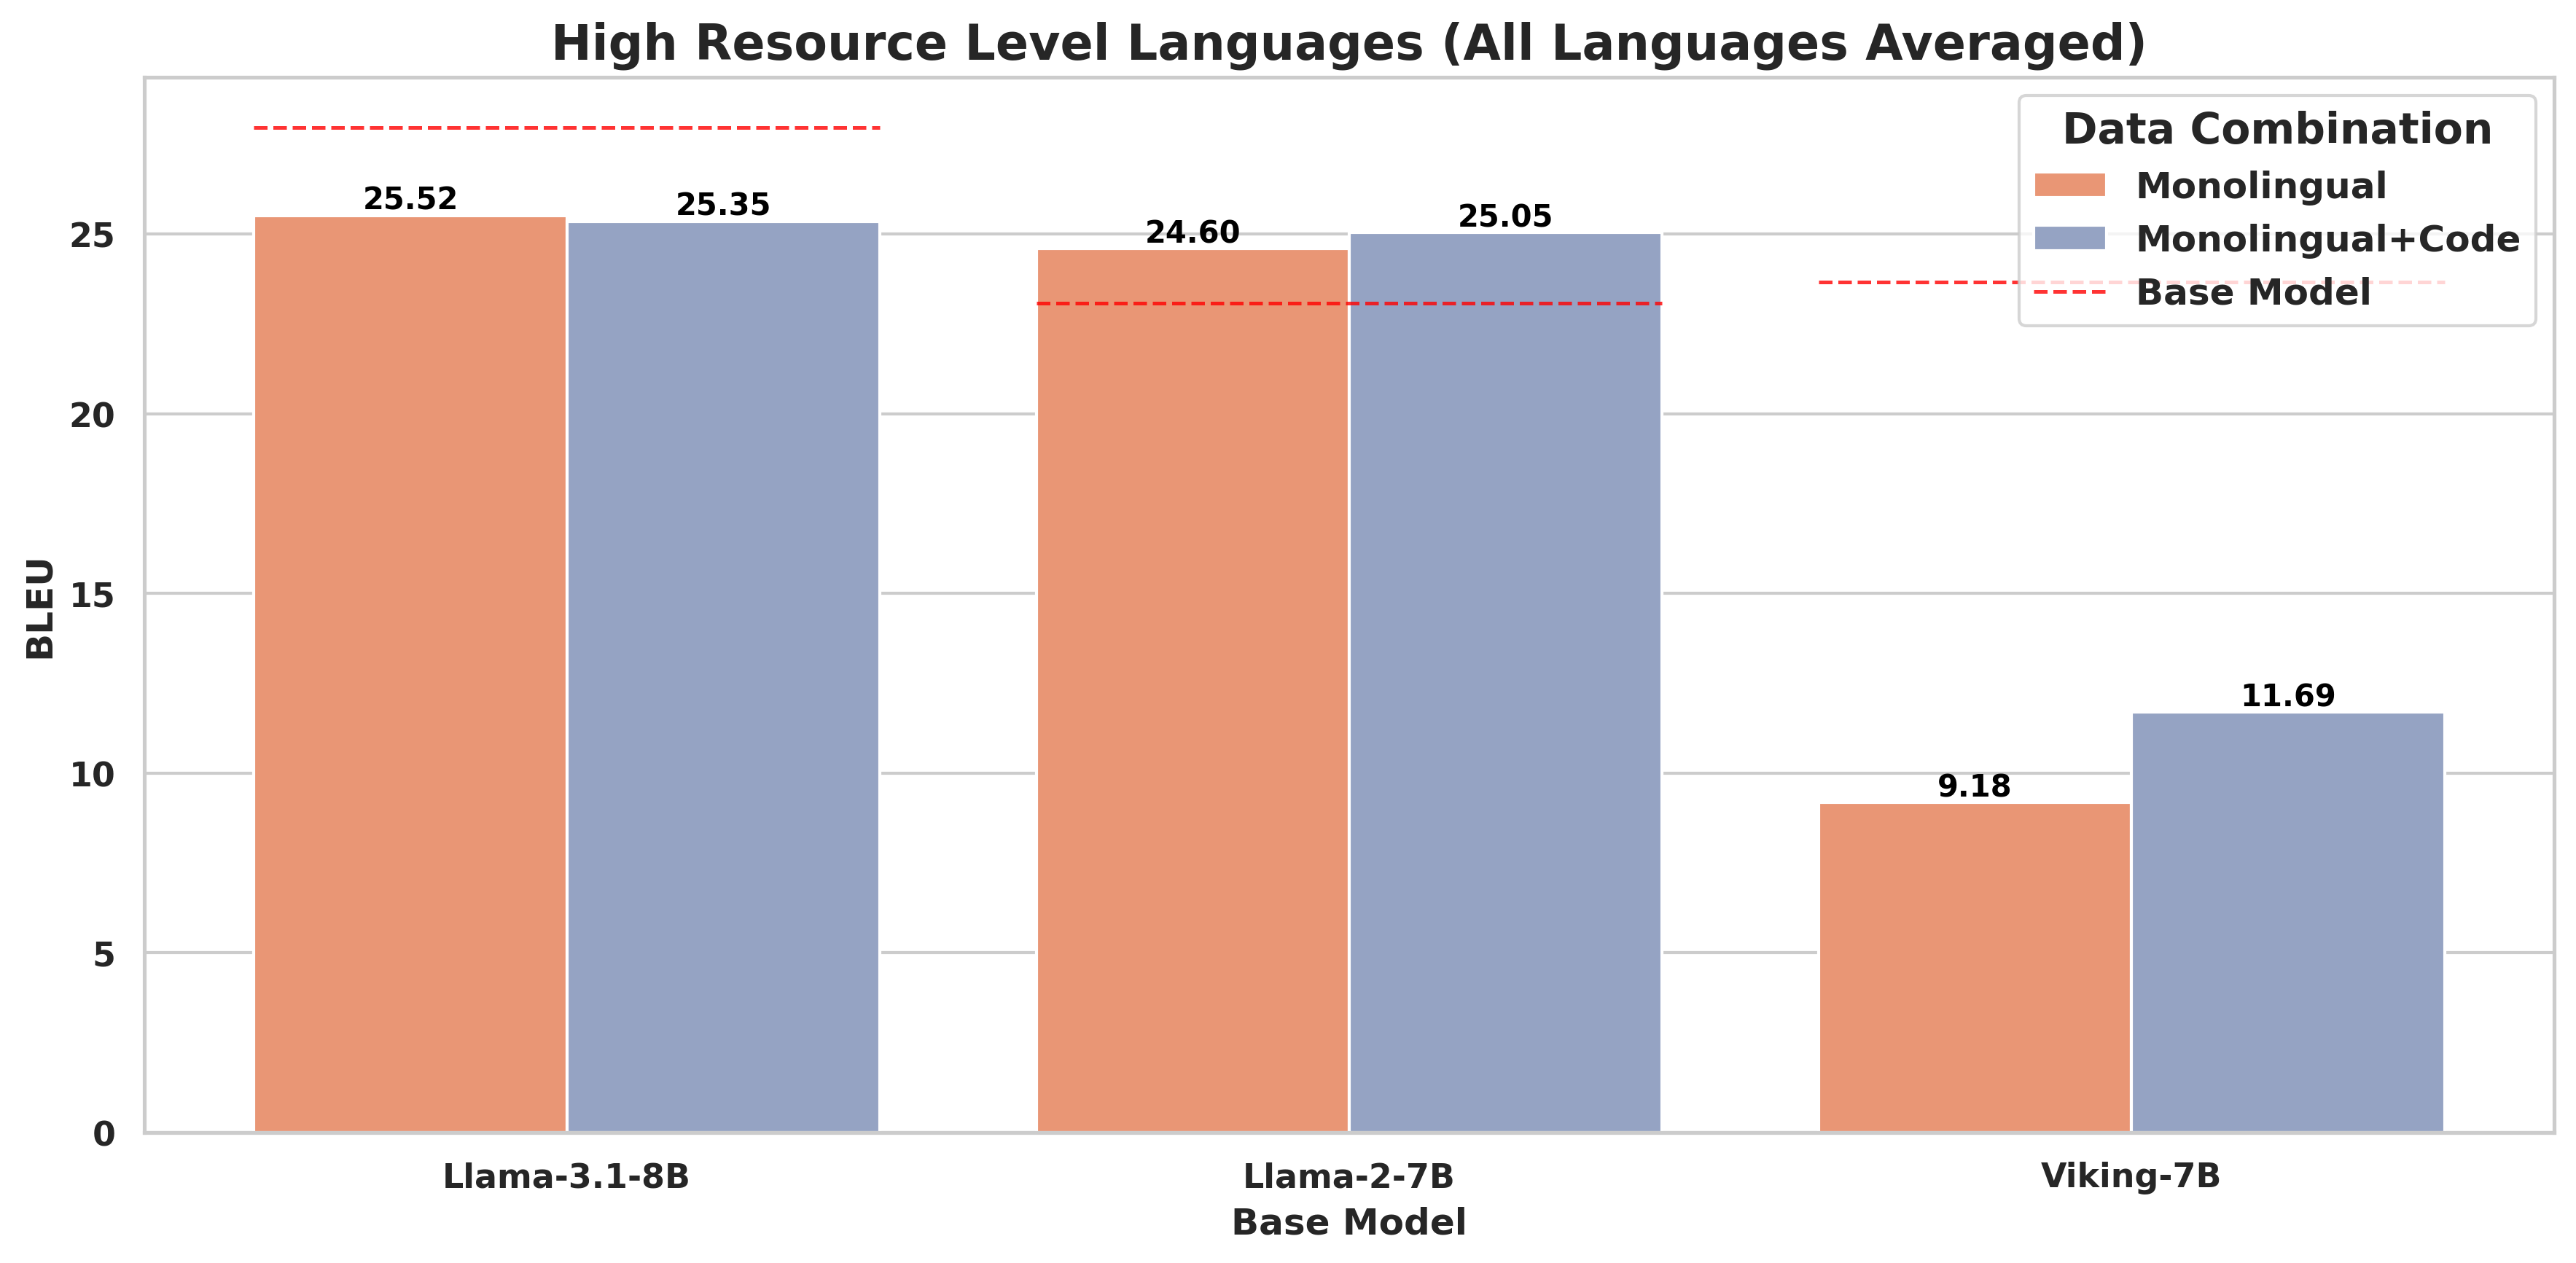

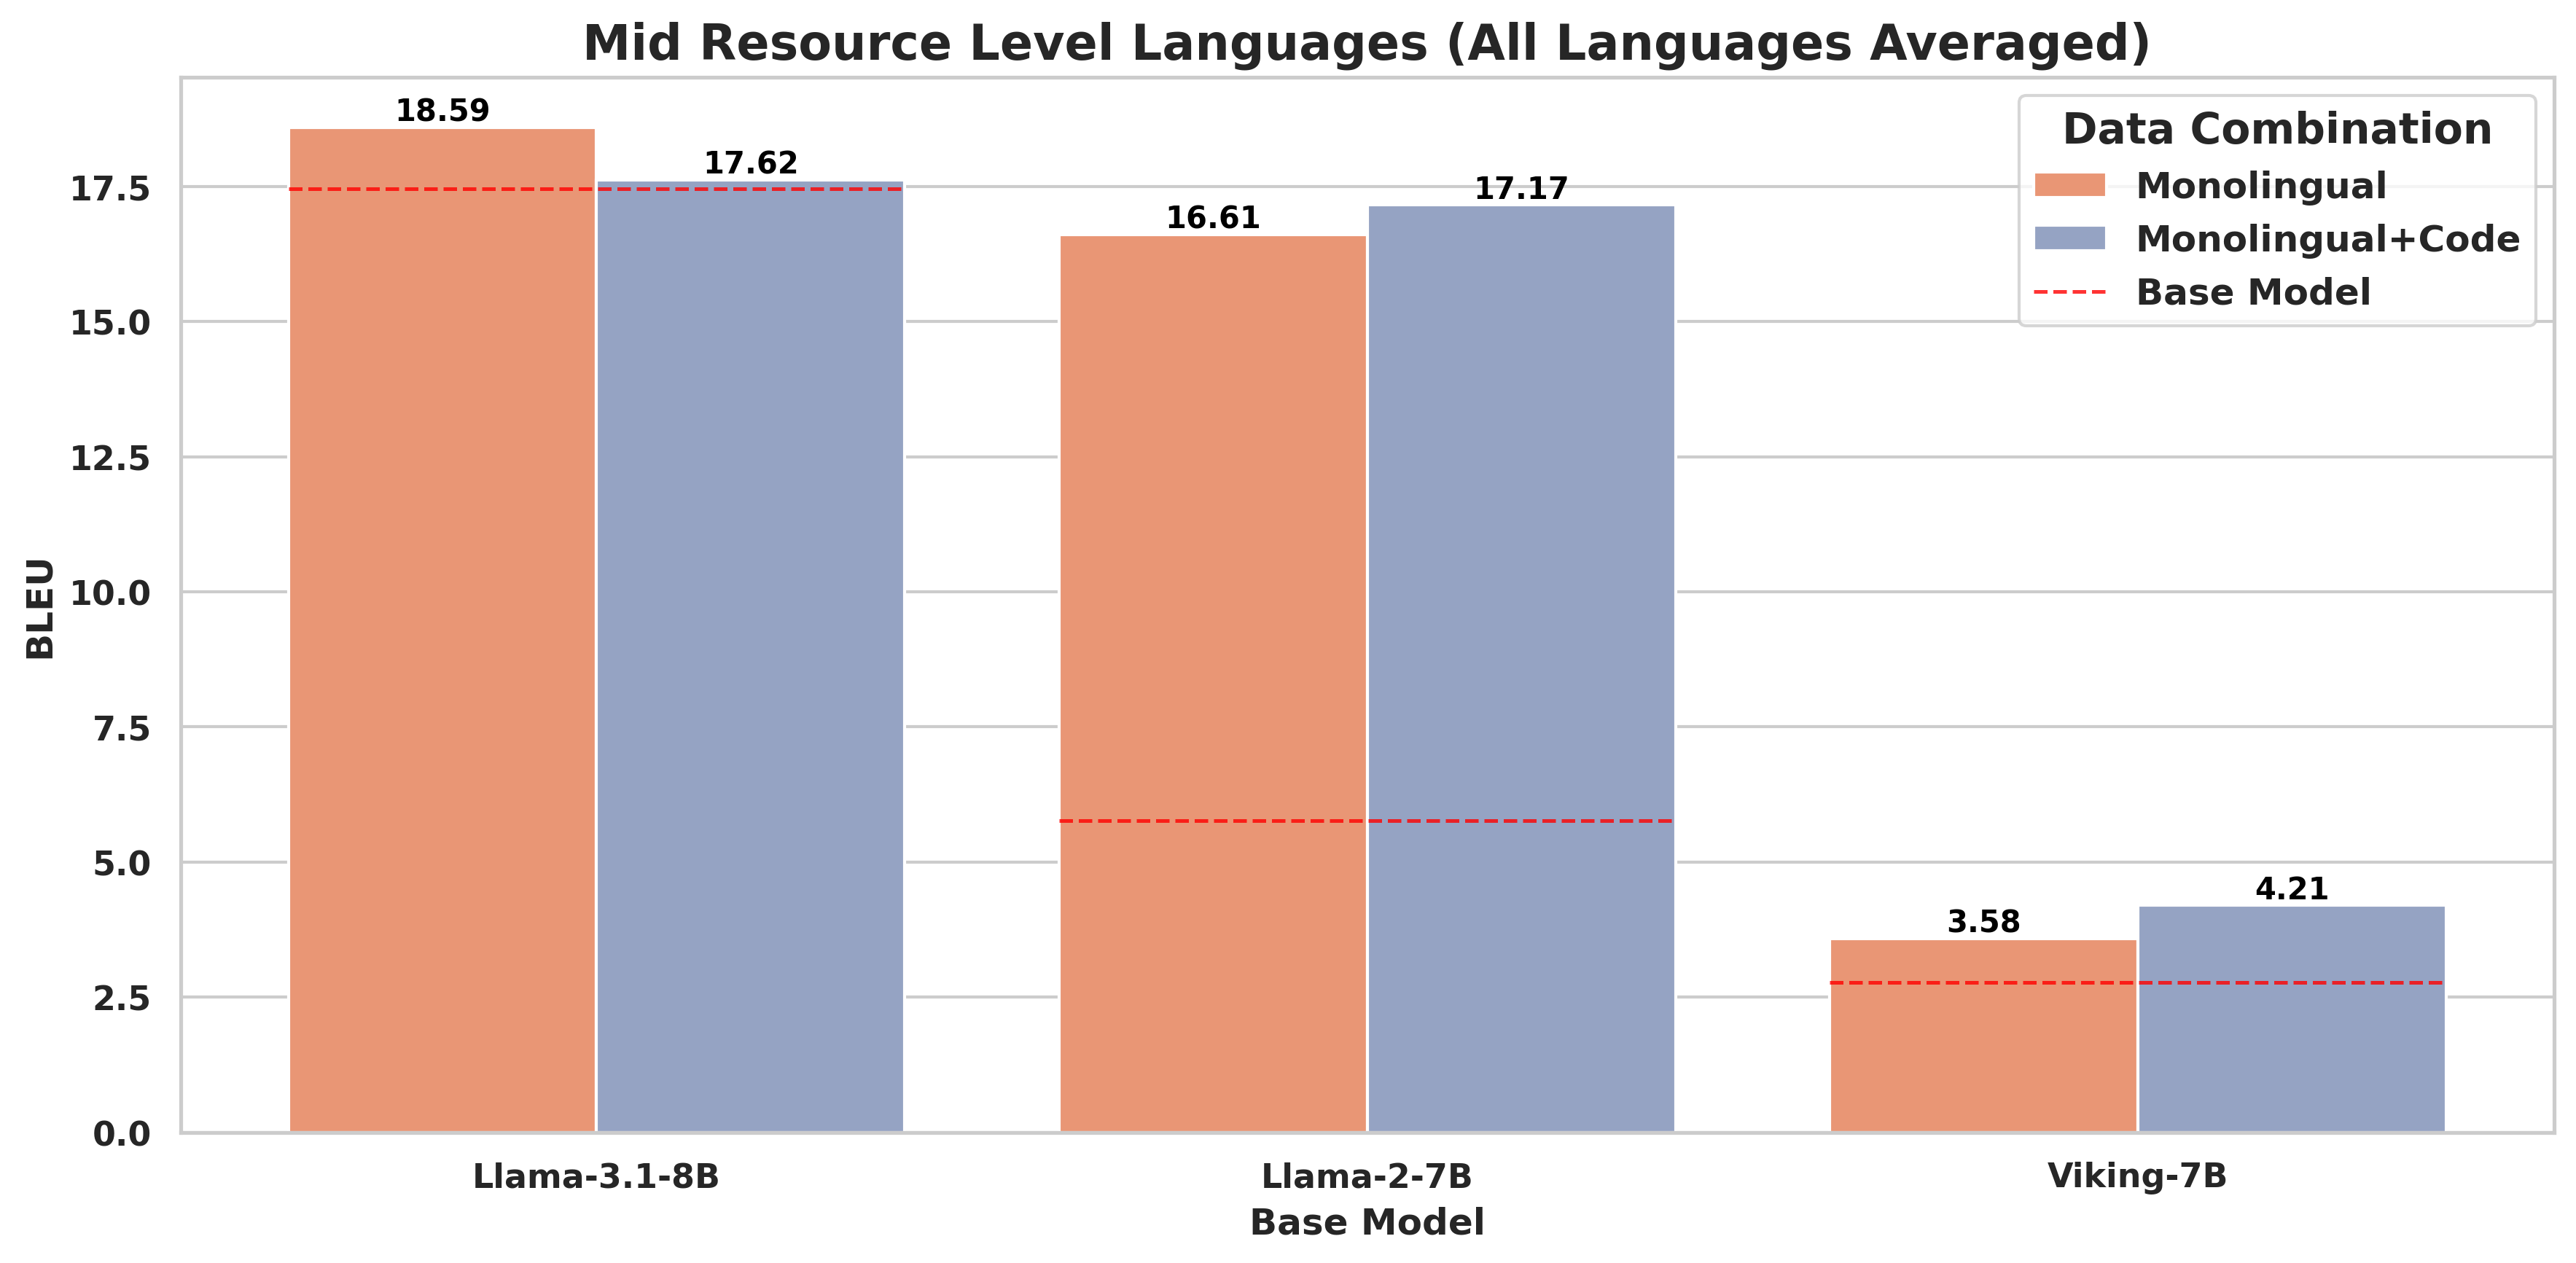

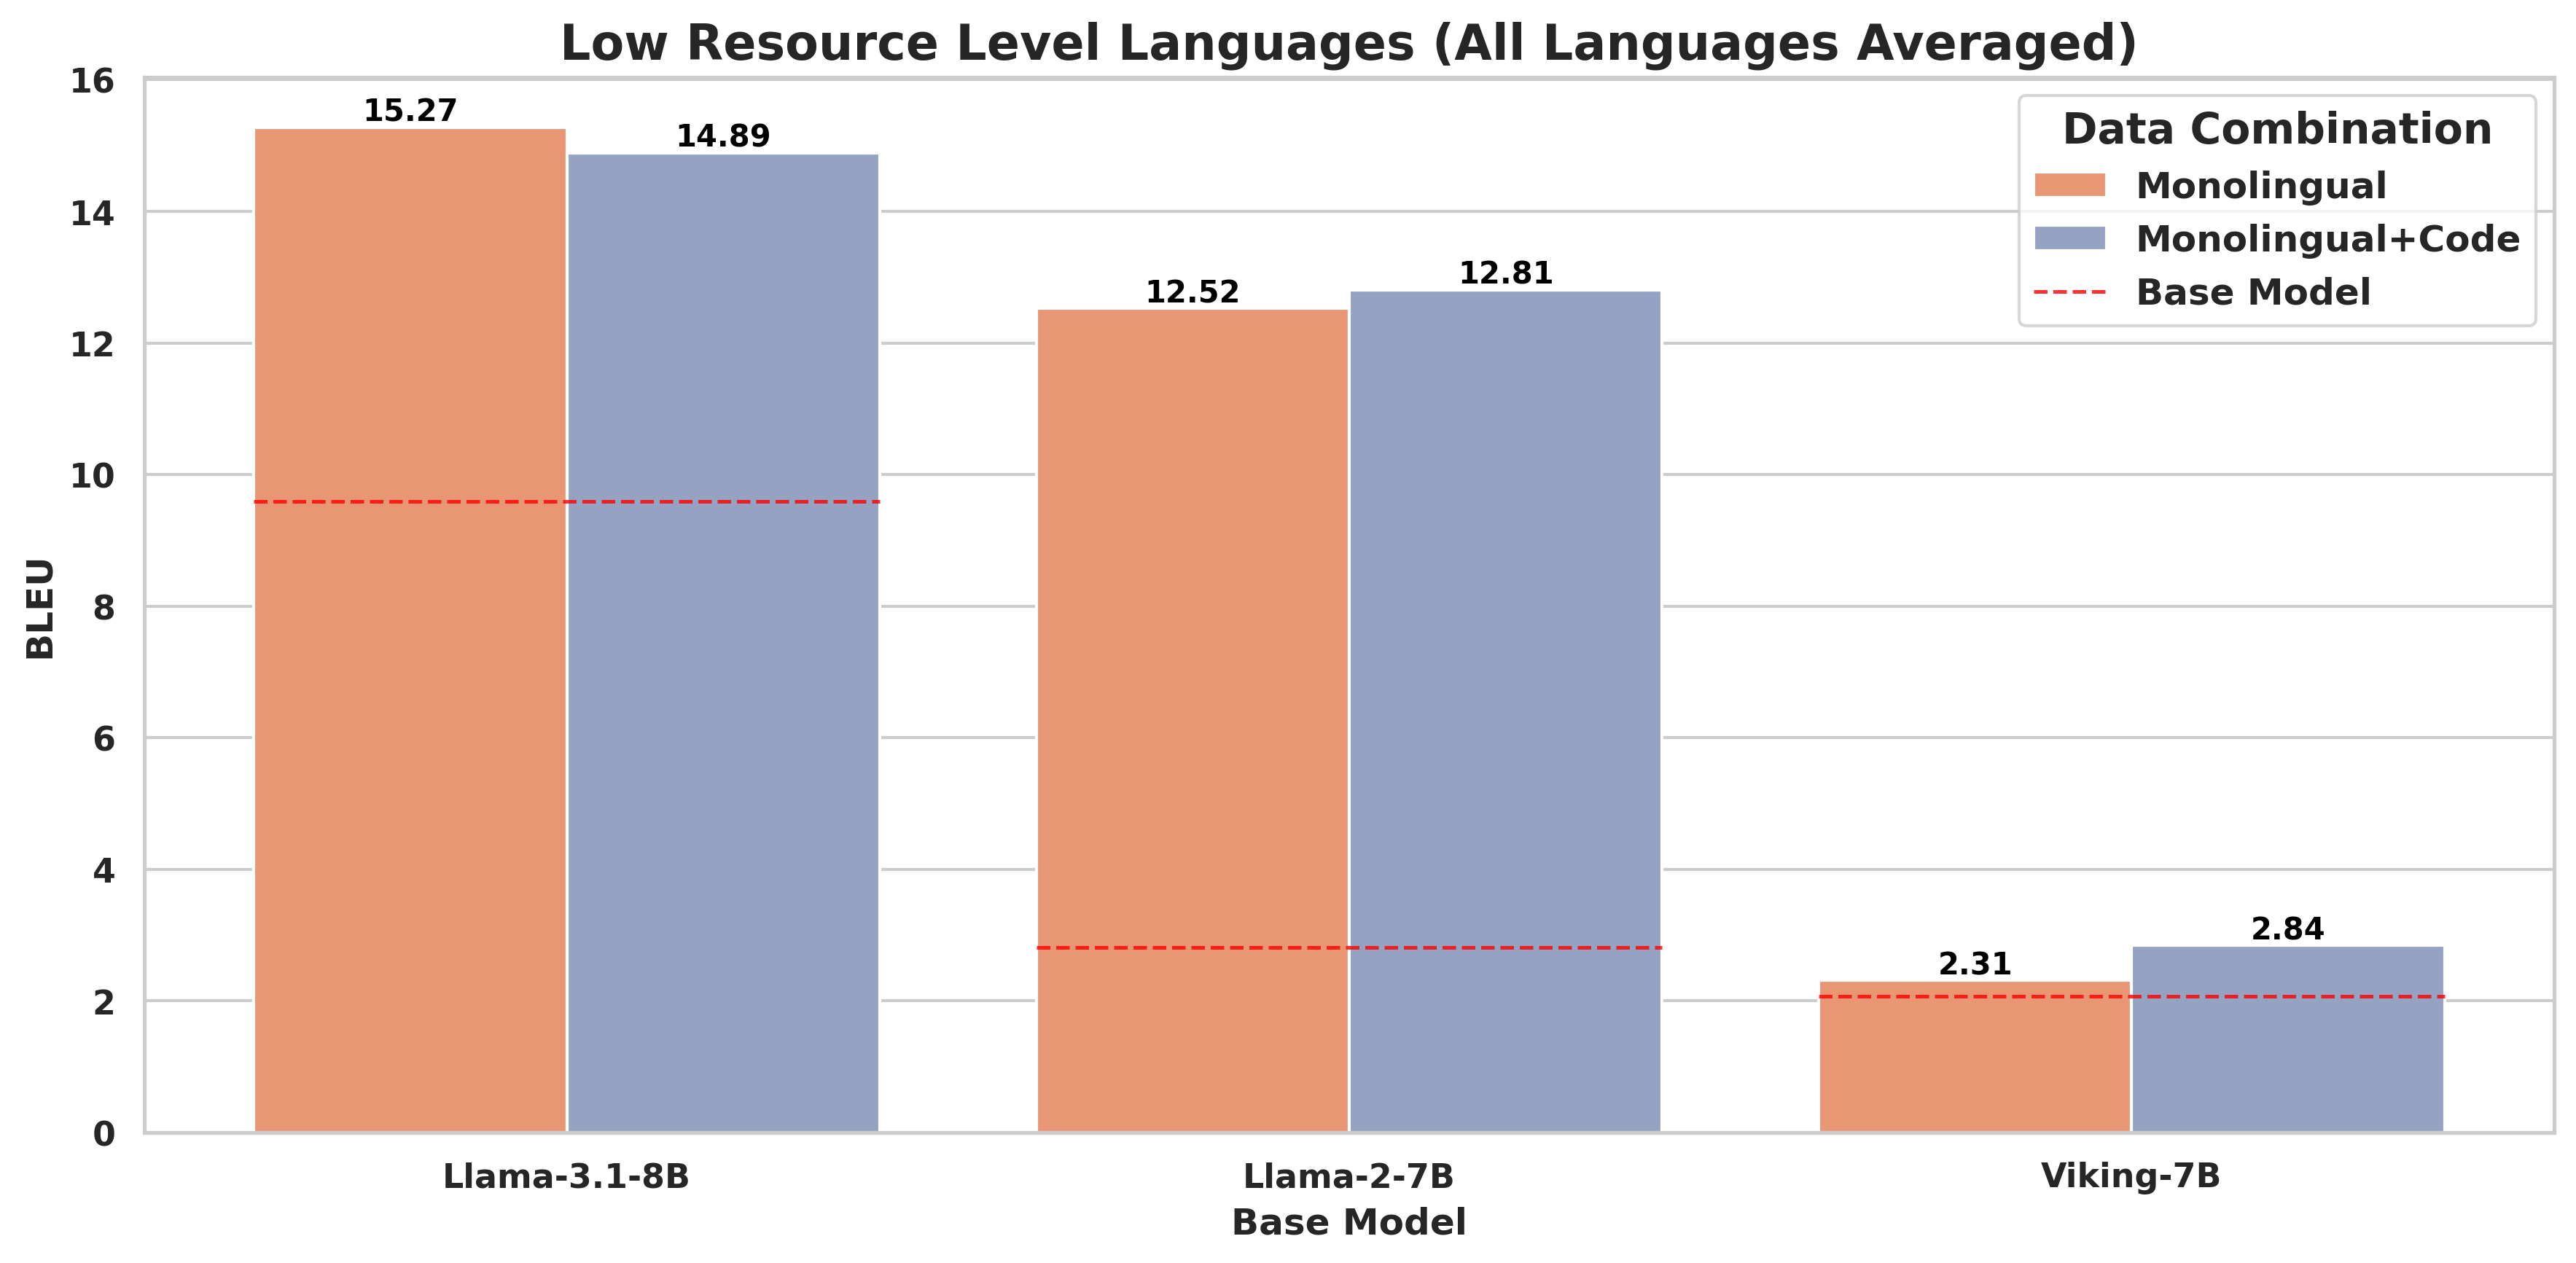

In [4]:
# Create separate plots for each resource level
for resource_level in resource_order:
    # Filter data for the current resource level
    df_resource = df_agg[df_agg['Resource_Level'] == resource_level]
    
    # Skip if no data for this resource level
    if df_resource.empty:
        continue
    
    plt.figure(figsize=(12, 6), dpi=300)
    g = sns.barplot(
        data=df_resource,
        x="Base_Model",
        y="Score",
        hue="Data_Combination",
        palette=custom_palette,
    )
    
    # Add baseline reference lines
    for x, base_model in enumerate(base_model_order):
        # Check if this combination exists in the baseline_scores dictionary
        if (base_model, resource_level) in baseline_scores:
            val = baseline_scores[(base_model, resource_level)]
            plt.hlines(
                y=val,
                xmin=x - 0.4,
                xmax=x + 0.4,
                color="red",
                linestyles="--",
                linewidth=1.2,
                alpha=0.8,
                label="Base Model" if x == 0 else "",  # Only label once
            )
    
    # Add score labels on top of bars
    for bar in g.patches:
        height = bar.get_height()
        if height > 0:
            g.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                color='black',
                fontweight='bold',
                fontsize=10
            )
    
    # Update legend labels
    handles, labels = g.get_legend_handles_labels()
    new_labels = [display_names.get(label, label) for label in labels]
    g.legend(handles=handles, labels=new_labels, title="Data Combination")
    
    plt.title(f"{resource_level} Resource Level Languages (All Languages Averaged)", fontsize=16, fontweight='bold')
    plt.xlabel("Base Model")
    plt.ylabel("BLEU")
    plt.tight_layout()
    plt.savefig(f"FLORES-200-X-Eng-{resource_level}-Resource-Averaged-Mono-Vs-MonoCode.pdf", format="pdf", bbox_inches="tight")
    plt.show()

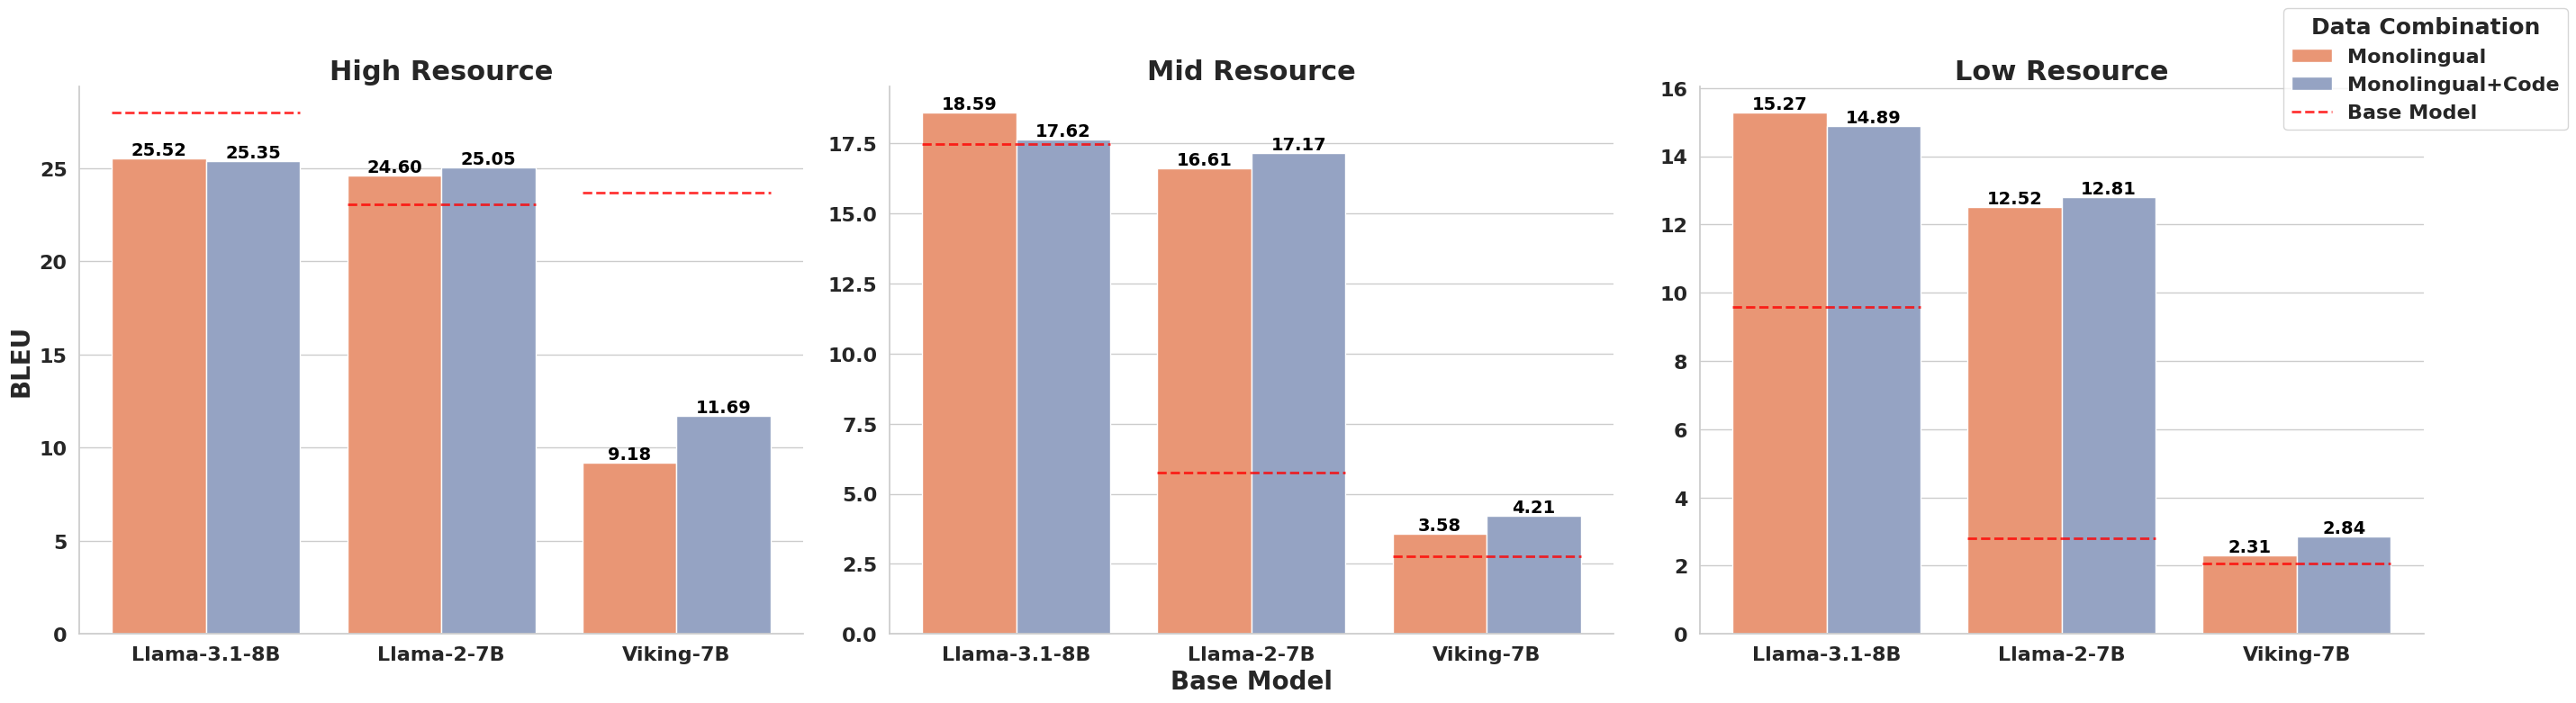

In [5]:
# 设置更大的全局字体参数
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 18,             
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.labelsize': 20,         
    'axes.titlesize': 22,        
    'axes.titleweight': 'bold',
    'legend.fontsize': 16,       
    'legend.title_fontsize': 18, 
    'xtick.labelsize': 16,       
    'ytick.labelsize': 16        
})

# 创建合并的图表
g = sns.FacetGrid(
    df_agg,
    col="Resource_Level",
    height=8,                   
    aspect=1.2,
    sharex=True,
    sharey=False,
)

# 绘制条形图，使用自定义调色板
g.map_dataframe(
    sns.barplot, 
    x="Base_Model", 
    y="Score", 
    hue="Data_Combination", 
    palette=custom_palette
)

# 获取第一个子图的图例句柄和标签
bar_handles, bar_labels = g.axes.flat[0].get_legend_handles_labels()

# 更新图例的标签
new_bar_labels = [display_names.get(label, label) for label in bar_labels]

# 为基准模型参考线创建单个线条
base_line = plt.Line2D([0], [0], color="red", linestyle="--", linewidth=2.0, alpha=0.8)

# 合并句柄和标签
all_handles = bar_handles + [base_line]
all_labels = new_bar_labels + ["Base Model"]  # 使用更新后的标签

# 添加基准参考线和分数标签，并处理轴标签
for i, (ax, resource_level) in enumerate(zip(g.axes.flat, resource_order)):
    for x, base_model in enumerate(base_model_order):
        # 检查此组合是否存在于基准分数字典中
        if (base_model, resource_level) in baseline_scores:
            val = baseline_scores[(base_model, resource_level)]
            ax.hlines(
                y=val,
                xmin=x - 0.4,
                xmax=x + 0.4,
                color="red",
                linestyles="--",
                linewidth=2.0,      
                alpha=0.8,
            )
    
    # 添加分数标签并增大字体
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                color='black',
                fontweight='bold',
                fontsize=14           
            )
    
    # 移除现有图例
    if ax.get_legend():
        ax.get_legend().remove()
    
    # 设置标题
    ax.set_title(f"{resource_level} Resource", fontweight='bold', fontsize=22)
    
    # 处理x轴标签
    if i == 1:  # 只在中间子图显示x轴标签
        ax.set_xlabel("Base Model", fontsize=20)
    else:
        ax.set_xlabel("", fontsize=20)  # 其他子图不显示x轴标签
    
    # 处理y轴标签
    if i == 0:  # 只在最左侧子图显示y轴标签
        ax.set_ylabel("BLEU", fontsize=20)
    else:
        ax.set_ylabel("", fontsize=20)  # 其他子图不显示y轴标签

# 创建统一的图例并放置在图形右上角，使用更新后的标签
g.fig.legend(
    all_handles, 
    all_labels, 
    loc='upper right', 
    bbox_to_anchor=(1.0, 1.0),
    title="Data Combination",
    frameon=True,
    fontsize=16,               
    title_fontsize=18          
)

# 调整布局以为图例留出空间
g.fig.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.savefig("FLORES-200-X-Eng-All-Resources-Averaged-Mono-Vs-MonoCode.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

In [6]:
# Create a table with the raw data
print("\nAverage Scores by Base Model, Data Combination, and Resource Level:")
pivot_table = df_agg.pivot_table(
    index=['Base_Model', 'Data_Combination'], 
    columns='Resource_Level', 
    values='Score',
    aggfunc='mean'
)
print(pivot_table.round(4))


Average Scores by Base Model, Data Combination, and Resource Level:
Resource_Level                    High      Mid      Low
Base_Model   Data_Combination                           
Llama-3.1-8B Monolingual       25.5198  18.5900  15.2748
             Monolingual-Code  25.3520  17.6210  14.8899
Llama-2-7B   Monolingual       24.5976  16.6130  12.5214
             Monolingual-Code  25.0473  17.1652  12.8066
Viking-7B    Monolingual        9.1799   3.5835   2.3082
             Monolingual-Code  11.6899   4.2090   2.8429


/tmp/ipykernel_2364552/2694222555.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df_agg.pivot_table(


In [7]:
# Create a table with baseline scores
print("\nBaseline Scores by Base Model and Resource Level:")
baseline_df = pd.DataFrame.from_dict(baseline_scores, orient='index').reset_index()
baseline_df.columns = ['Model_Resource', 'Score']
baseline_df[['Base_Model', 'Resource_Level']] = pd.DataFrame(baseline_df['Model_Resource'].tolist(), index=baseline_df.index)
baseline_pivot = baseline_df.pivot(index='Base_Model', columns='Resource_Level', values='Score')
print(baseline_pivot.round(4))



Baseline Scores by Base Model and Resource Level:
Resource_Level    High     Low     Mid
Base_Model                            
Llama-2-7B      23.075  2.8117   5.765
Llama-3.1-8B    27.970  9.5900  17.460
Viking-7B       23.675  2.0667   2.770
